In [1]:
%load_ext autoreload
%autoreload 1
%autosave 60

Autosaving every 60 seconds


In [2]:
import sys
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sb
from scipy import stats
from sklearn.decomposition import PCA
import scanpy
from anndata import AnnData
import umap
import anndata
import requests
import json

In [3]:
sys.path.append("/u/davidm/Documents/Memoire/Scripts/RNA-seq/python/")

In [4]:
import RNAseq
importlib.reload(RNAseq)

<module 'RNAseq' from '/u/davidm/Documents/Memoire/Scripts/RNA-seq/python/RNAseq.py'>

In [5]:
cell_line = "MCF7-atcc"
project = "sc-MCF7+MDAMB231-pmig-GRHL2_DSP1090"

### Plotting parameters

In [6]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.family'] = 'DeJavu Serif'

### Raw CB frequency

In [7]:
y = pd.read_table(f"/home/arion/davidm/Data/datasets/private/RNA-seq/sc/{project}/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh/raw/{cell_line}/alevin/raw_cb_frequency.txt", header=None)[1]

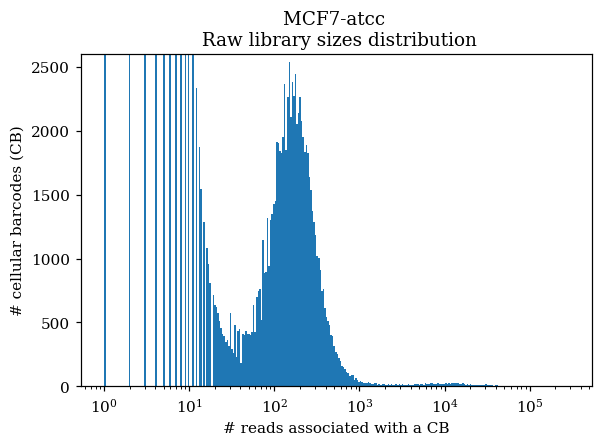

In [8]:
plt.title(f"{cell_line} \n Raw library sizes distribution")
plt.ylim(0,2600);
plt.xlabel("# reads associated with a CB")
plt.ylabel("# cellular barcodes (CB)")
RNAseq.plot_loghist(y, bins=300)

In [9]:
x = pd.read_table(f"/home/arion/davidm/Data/datasets/private/RNA-seq/sc/{project}/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh/raw/{cell_line}/alevin/featureDump.txt")

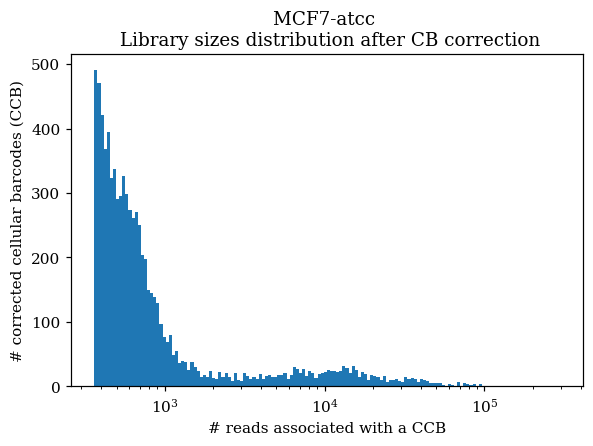

In [10]:
plt.title(f"{cell_line} \n Library sizes distribution after CB correction")
plt.xlabel("# reads associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
RNAseq.plot_loghist(x["CorrectedReads"], bins=150)

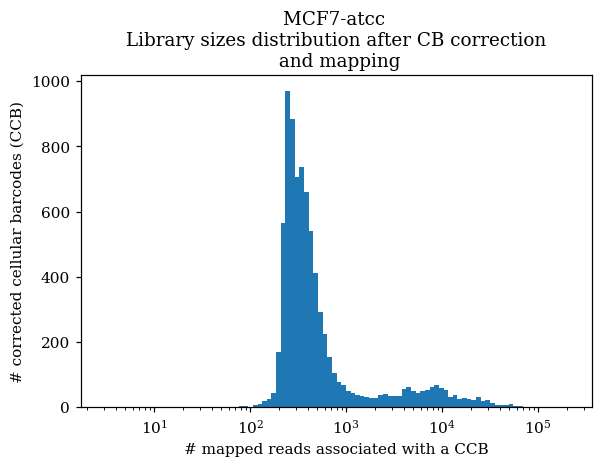

In [11]:
plt.title(f"{cell_line} \n Library sizes distribution after CB correction \n and mapping")
plt.xlabel("# mapped reads associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
RNAseq.plot_loghist(x["MappedReads"], bins=100)

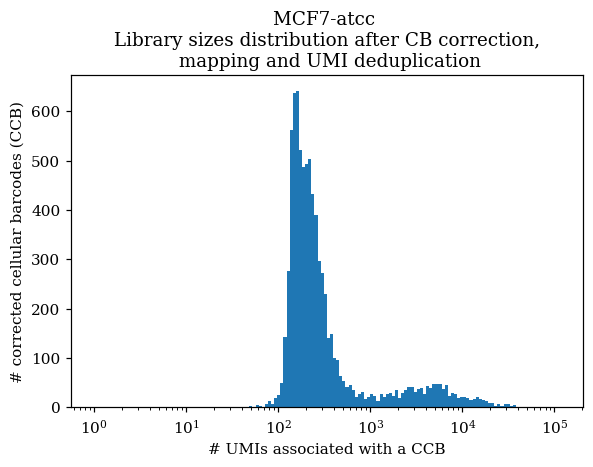

In [12]:
plt.title(f"{cell_line} \n Library sizes distribution after CB correction, \n mapping and UMI deduplication")
plt.xlabel("# UMIs associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
RNAseq.plot_loghist(x["DeduplicatedReads"], bins=150)

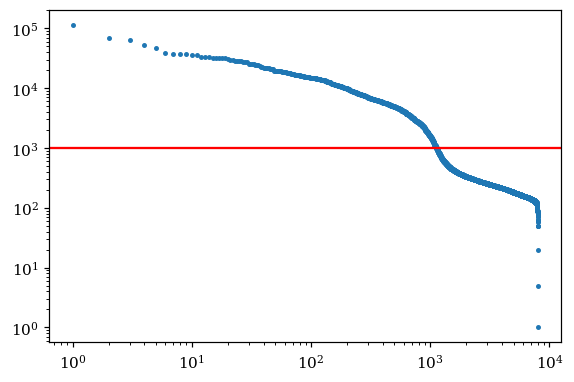

In [13]:
u = x["DeduplicatedReads"].values
u = u[np.argsort(-u)]
plt.scatter(np.arange(1, len(u)+1), u, s= 5)
plt.xscale("log")
plt.yscale("log")
plt.axhline(y=1000, c = "red")

### Loading raw count matrix

In [14]:
sc = RNAseq.sc_Dataset(project_path = f"/home/arion/davidm/Data/datasets/private/RNA-seq/sc/{project}", samples_id = "condition", samples= [cell_line], quant_tool="alevin", quant_params = 'trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh', pp = "raw", cdna = "3' tag")
sc.save()

Annotating condition...
Annotating barcodes...
Annotating total_UMIs...
Annotating #_genes...


In [16]:
sc.mtx.shape

(7969, 20305)

### Non stringent filtering

In [17]:
sc.reload()

__QC before filtering__

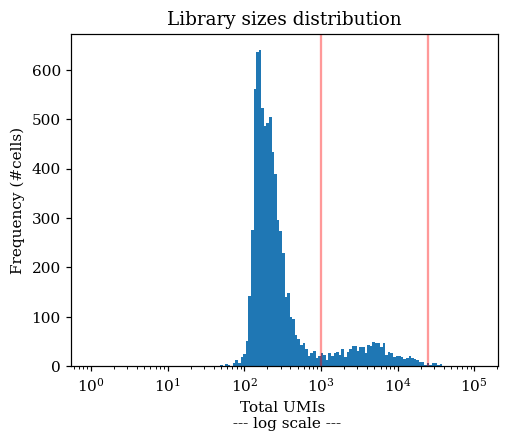

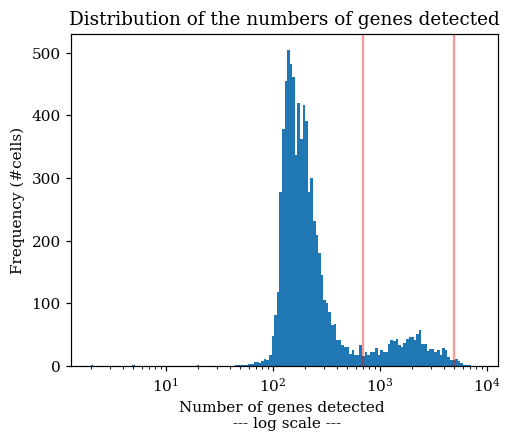

max_corr already annotated. Set ow = True if you want to overwrite.


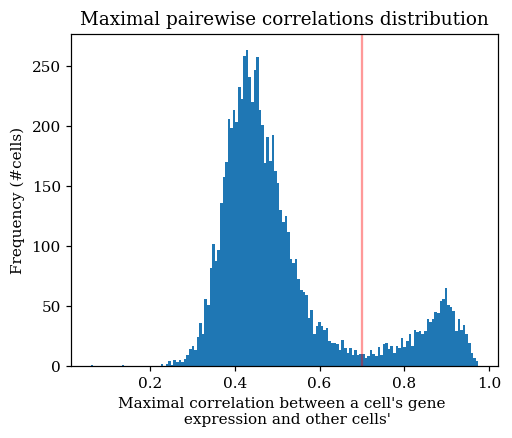

mt_frac already annotated. Set ow = True if you want to overwrite.


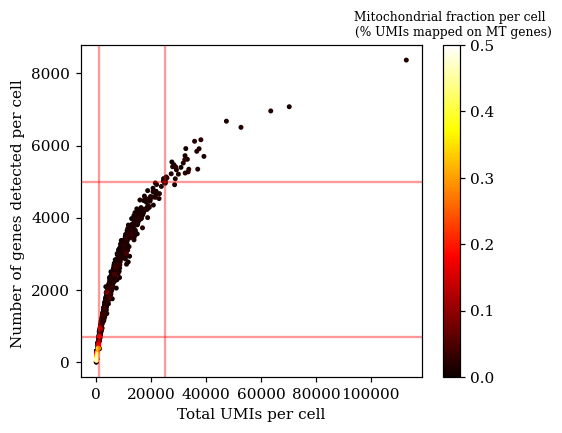

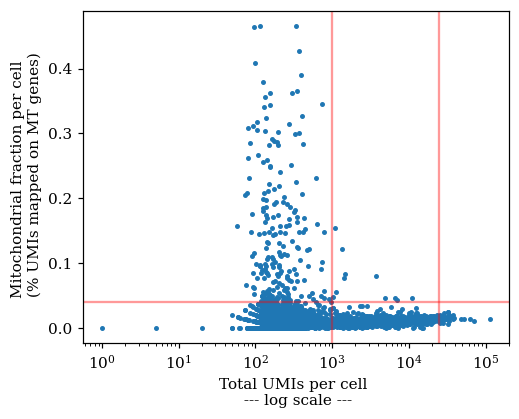

In [21]:
sc.plot_qc(n_counts_max=25000, n_counts_min = 1000, n_genes_max=5000, n_genes_min = 700, mt_max = 0.04, max_corr_thr = 0.7, n_bins = 150)
sc.save()

In [ ]:
# sc.lib_size_normalization(plot = False)
# sc.dim_reduc(method = "pca", n_components = 50, plot = False)
# sc.dim_reduc(method = "umap", layer = "pca", color_by = "total_UMIs", color_log_scale=True)

__Filtering cells__

In [22]:
sc.reload()
sc.filter_cells(n_counts_max=25000, n_counts_min = 1000, n_genes_max=5000, n_genes_min = 700, mt_max = 0.04, max_corr_thr = 0.7);
sc_ns = sc.copy()
sc_ns.save()

In [94]:
sc_ns.mtx.shape

(2118, 20305)

__QC after filtering__

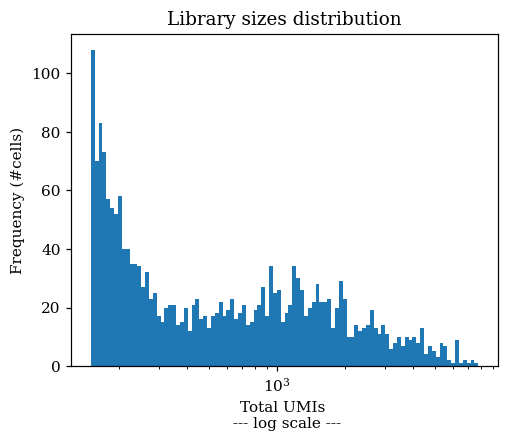

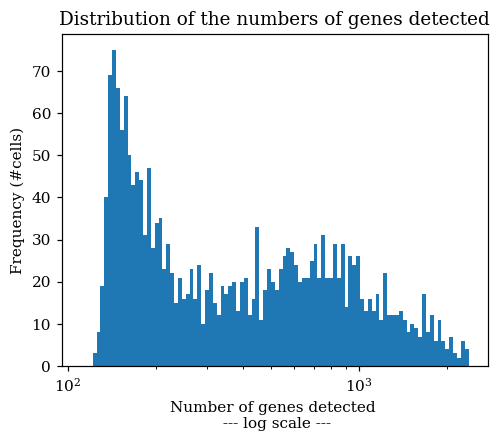

max_corr already annotated. Set ow = True if you want to overwrite.


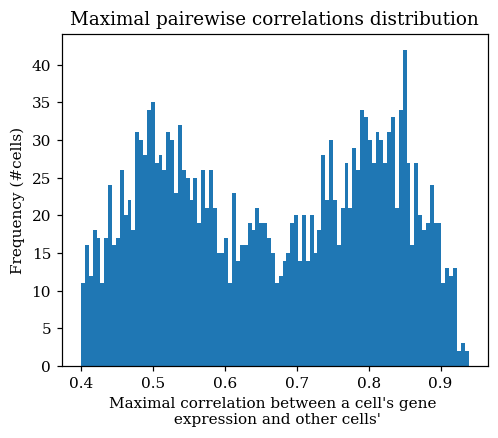

mt_frac already annotated. Set ow = True if you want to overwrite.


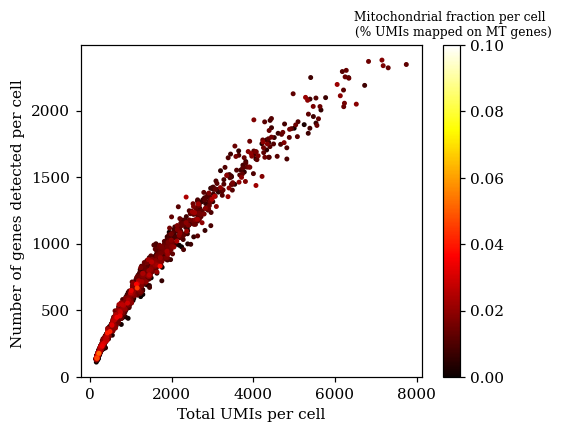

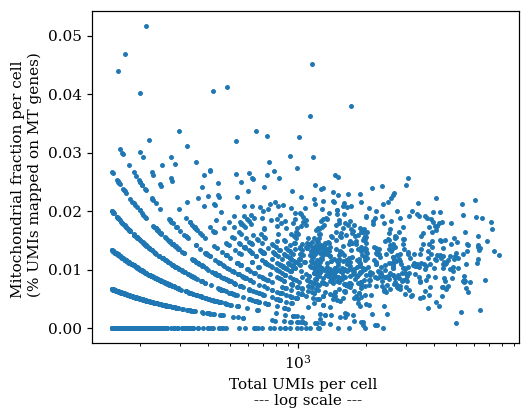

In [95]:
sc_ns.plot_qc(show_cutoffs=False)

Dataset already log-normalized. To overwrite, set ow = True.


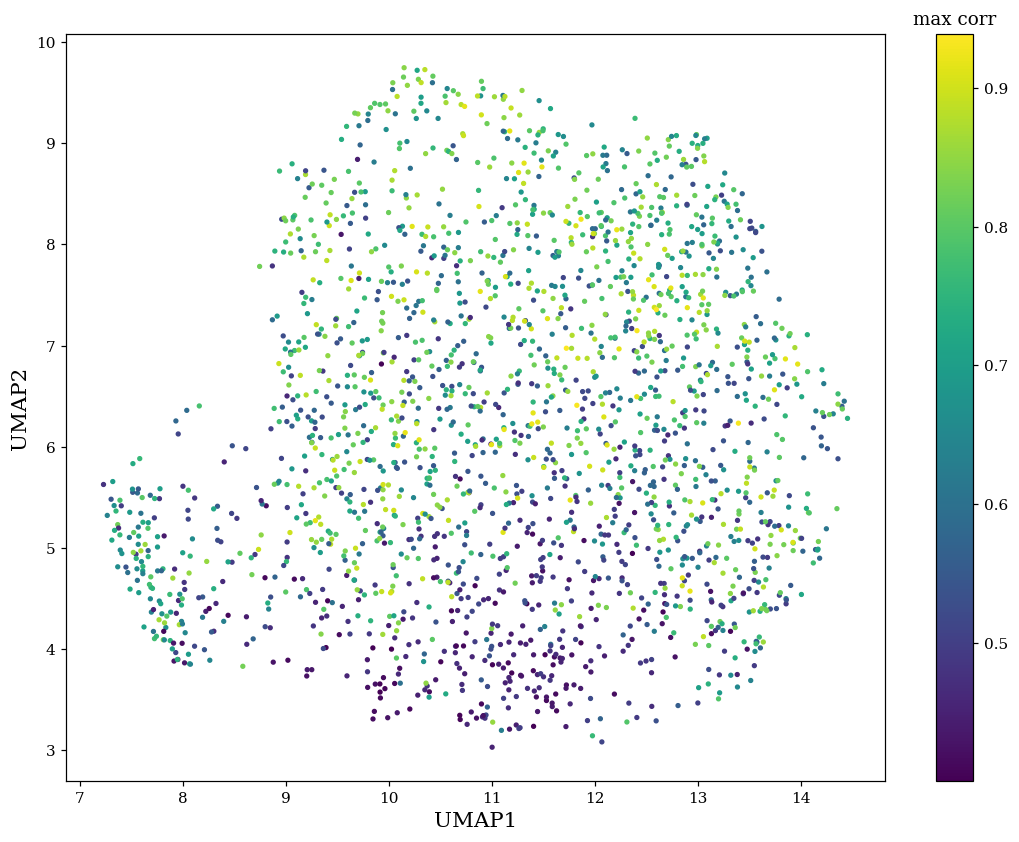

In [100]:
sc_ns.reload()
sc_ns.lib_size_normalization(plot = False)
sc_ns.dim_reduc(method = "pca", n_components = 20, plot = False)
sc_ns.dim_reduc(method = "umap", layer = "pca", color_by = "max_corr",  markersize = 6, min_dist = 0.2)

In [14]:
import scvi

In [84]:
sc_ns.biomart_server

'http://apr2020.archive.ensembl.org/biomart/'

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 1549 cells, 20305 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
INFO     Training for 50 epochs                                                              
INFO     Training without KL warmup                         

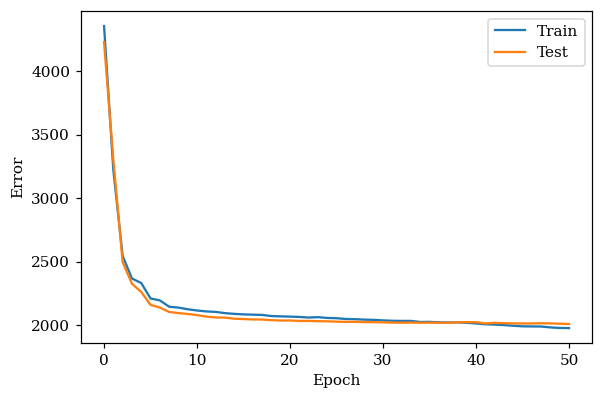

In [85]:
sc_ns.reload()
# sc_ns.annotate_genes(genes_annot_name = "external_gene_name")

# sc.select_genes(genes_annot_name="ensembl_gene_id", genes_annot=vg)
# sc.annotate_samples(samples_annot_name="rp_frac")
adata_scvi = AnnData(sc_ns.mtx, obs={"condition":sc_ns.condition}, var={"var_names":sc_ns.ensembl_gene_id})
# scvi.data.poisson_gene_selection(adata_scvi,
#                                  #batch_key='batch', # estimate a dispersion parameter batchwise
#                                  n_top_genes = 1000, # how many genes to select
#                                  n_samples=30000
#                                  )
# adata_scvi = adata_scvi[:,adata_scvi.var['highly_variable']]
adata_scvi = adata_scvi.copy()
scvi.data.setup_anndata(adata_scvi) #batch_key="rp_frac") #, labels_key='cell_line') # batch_key = 'project' => not good : dsp762 contains only luminals, remove signal !

### DEFINE MODEL
model = scvi.model.SCVI(adata_scvi,  
                        n_hidden=128, 
                        n_layers=1,
                        n_latent=20,
                        )

# MODEL TRAINING
model.train(frequency=1, 
            n_epochs = 50,
            lr=2e-3,
            n_epochs_kl_warmup=None)

train_test_results = pd.DataFrame(model.trainer.history).rename(columns={'elbo_train_set':'Train', 'elbo_test_set':'Test'})
print(train_test_results)

ax = train_test_results.plot()
ax.set_xlabel("Epoch")
ax.set_ylabel("Error")
plt.show()

In [86]:
sc_ns.scvi = model.get_latent_representation()
sc_ns.layers["reduced"].append("scvi")
# sc.imp_mtx = model.get_normalized_expression(library_size=np.median(sc.mtx.sum(1))).values
# sc.layers["full"].append("imp_mtx")
# sc_ns.save()

l = model.get_latent_library_size()

del adata_scvi, model

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


In [87]:
# sc_ns.reload()
sc_ns.dim_reduc(method = "umap", layer = "scvi", color_by = "total_UMIs",  color_log_scale=True, markersize = 6, min_dist = 0.2)

AttributeError: 'sc_Dataset' object has no attribute 'scvi'

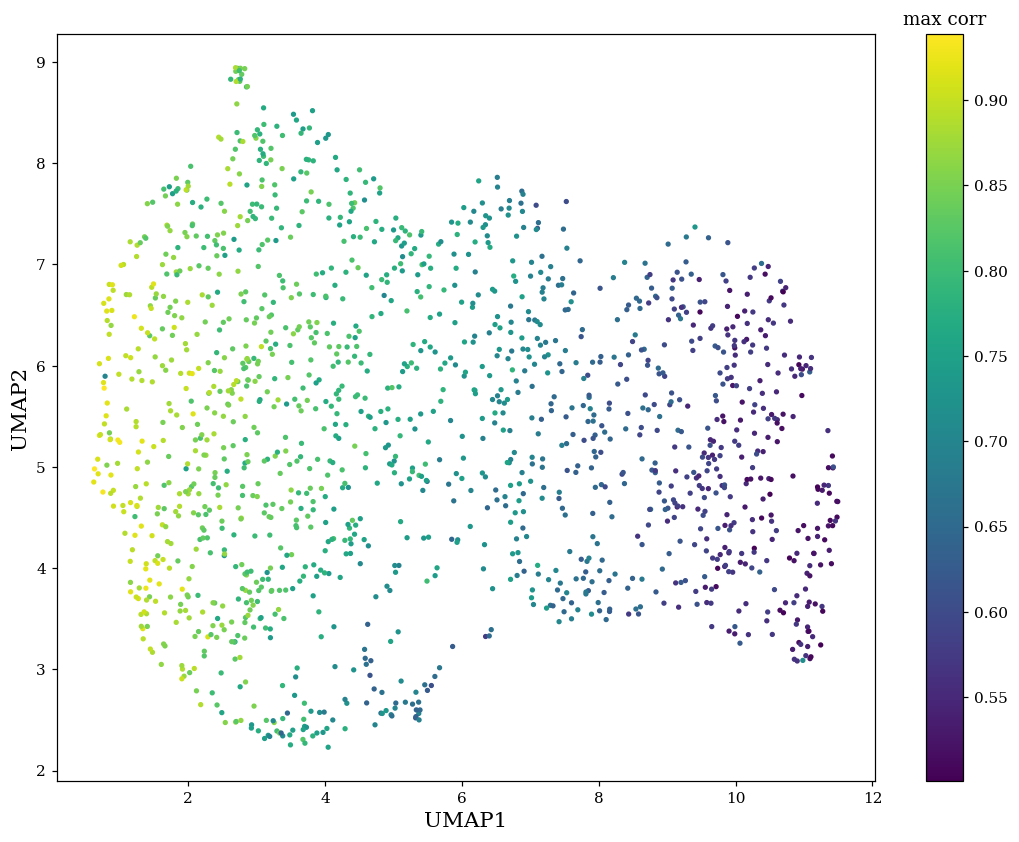

In [21]:
sc_ns.reload()
sc_ns.dim_reduc(method = "umap", layer = "scvi", color_by = "max_corr", markersize = 6, min_dist = 0.2)

### Stringent filtering

In [23]:
sc.reload()

__QC__

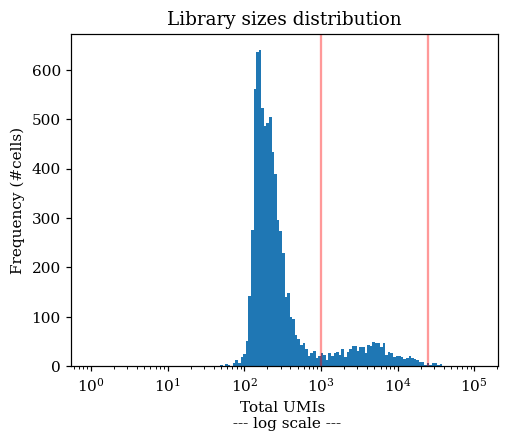

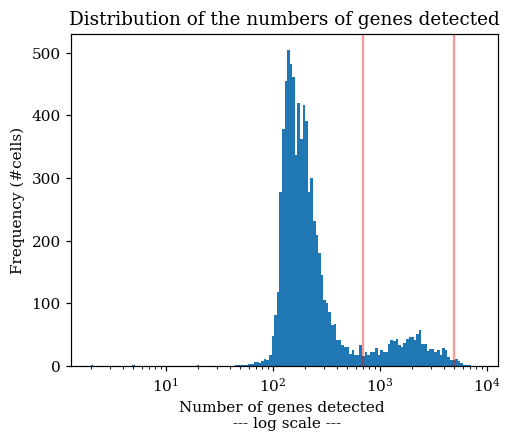

max_corr already annotated. Set ow = True if you want to overwrite.


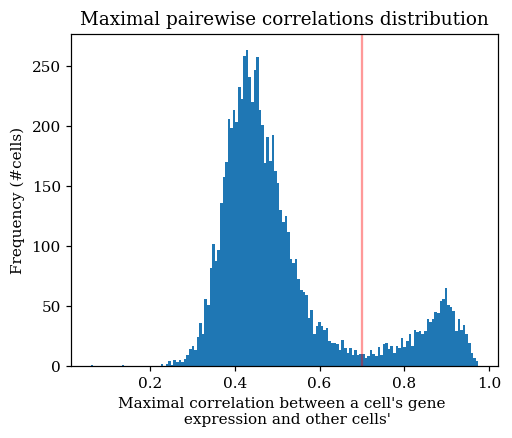

mt_frac already annotated. Set ow = True if you want to overwrite.


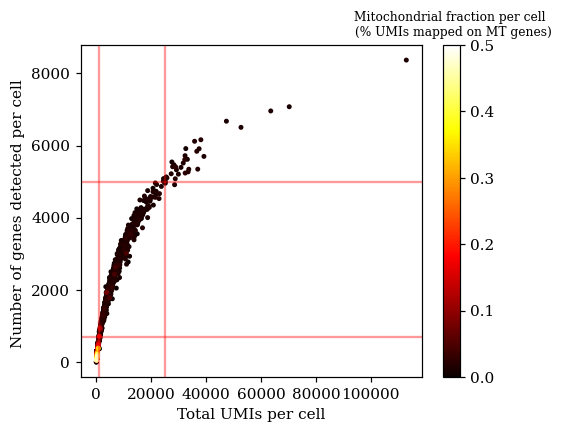

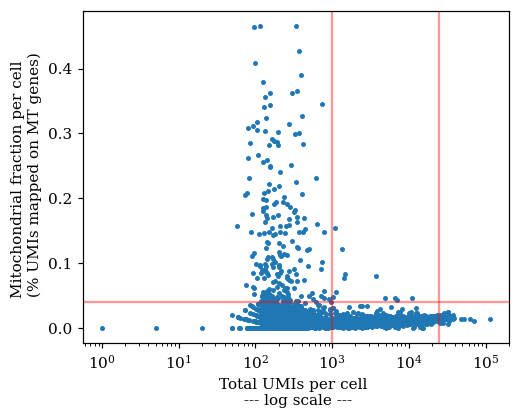

In [24]:
sc.plot_qc(n_counts_max=25000, n_counts_min = 1000, n_genes_max=5000, n_genes_min = 700, mt_max = 0.04, max_corr_thr = 0.7, n_bins = 150)

__Filtering cells__

In [25]:
sc_s = sc.copy()
sc_s.filter_cells(n_counts_max=25000, n_counts_min = 1000, n_genes_max=5000, n_genes_min = 700, mt_max = 0.04, max_corr_thr = 0.7);
sc_s.save()

In [26]:
sc_s.mtx.shape

(1044, 20305)

__QC after filtering__

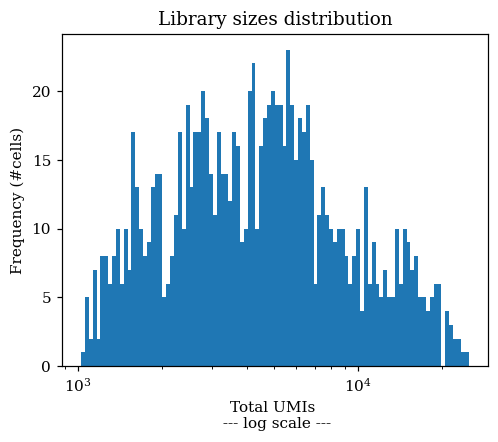

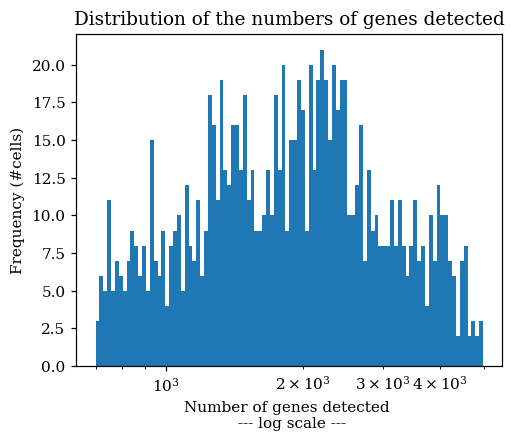

max_corr already annotated. Set ow = True if you want to overwrite.


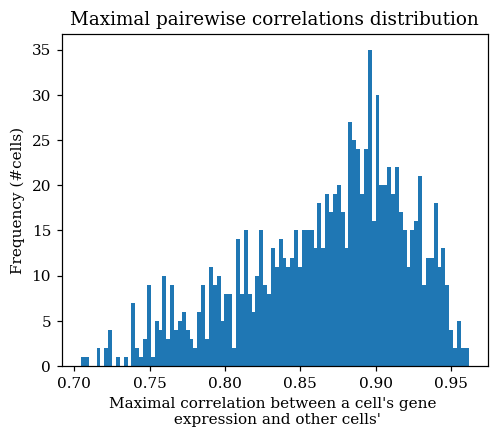

mt_frac already annotated. Set ow = True if you want to overwrite.


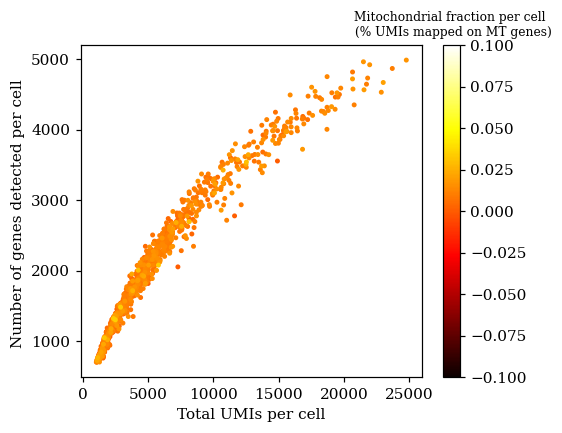

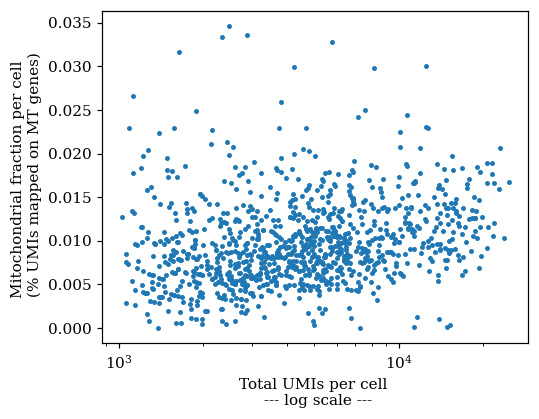

In [27]:
sc_s.plot_qc(show_cutoffs=False)

__Saving filtered count matrix__

In [28]:
sc_s.save_files(pp="filtered")

### Compare stringent & non stringent filtring

In [47]:
sc_ns.reload()
sc_ns.annotate_genes(genes_annot_name="external_gene_name")
sc_ns.annotate_samples(samples_annot_name="qc", samples_annot = np.array(["stringent" if b in sc_s.barcodes else "non-stringent" for b in sc_ns.barcodes], dtype = str), ow = True)
sc_ns.save()

Annotating external_gene_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...
Annotating qc...


In [ ]:
# rep = 30
# sc_ns.reload()
# b = np.repeat(np.arange(0,rep).reshape(1, -1), len(sc_ns.mtx)//(rep-2), axis = 0).ravel()
# b = b[:len(sc_ns.mtx)].astype(str)
# np.random.shuffle(b)
# sc_ns.annotate_samples(samples_annot_name="batch", samples_annot=b)
# ps = sc_ns.pseudobulk(group_by_annot_name = ["qc", "batch"])

# ps.annotate_genes(genes_annot_name = "external_gene_name")
# ps.downsample(libs = 3000)

# ps.save()

# ps.lib_size_normalization(1e3)

# ps.ttest(samples_annot_name="qc", samples_annot_ref="stringent", samples_annot_test="non-stringent", top = 30, qval_cutoff = 0.05)

Dataset already log-normalized. To overwrite, set ow = True.


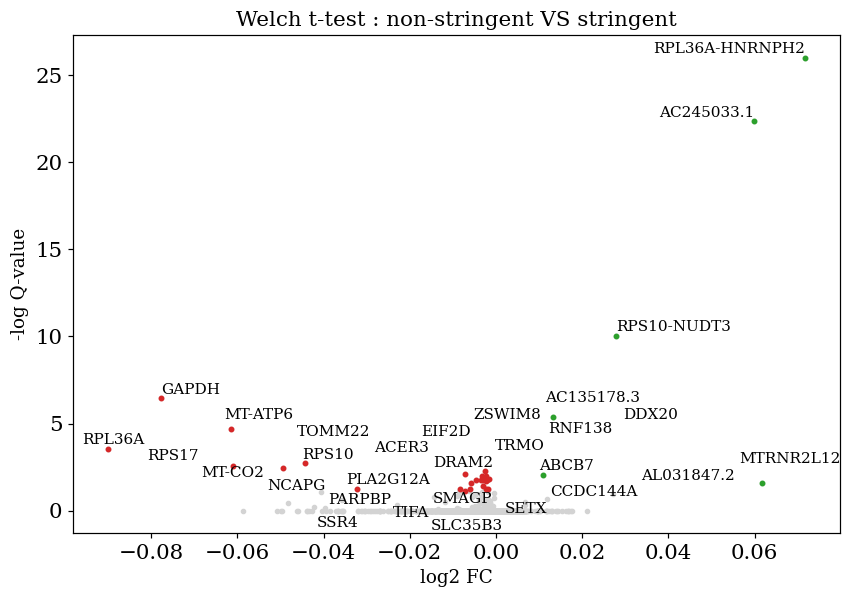

In [40]:
sc_ns.reload()
i1 = np.random.choice(np.argwhere(sc_ns.qc == "stringent").ravel(), (sc_ns.qc == "non-stringent").sum())
i2 = np.argwhere(sc_ns.qc == "non-stringent").ravel()
sc_ns.update_samples(np.concatenate([i1, i2]))
# sc_ns.downsample(libs = int(min(sc_ns.mtx.sum(1))))
sc_ns.lib_size_normalization()

sc_ns.ttest(samples_annot_name="qc", samples_annot_ref="stringent", samples_annot_test="non-stringent", top = 30, qval_cutoff = 0.05)

In [57]:
sc_ns.mtx.shape

(219, 20305)

In [61]:
_, x1 = sc_ns.select_samples(samples_annot_name = "qc", samples_annot = "non-stringent", return_layer = "log_norm_mtx")
_, x2 = sc_ns.select_samples(samples_annot_name = "qc", samples_annot = "stringent", return_layer = "log_norm_mtx")
log2fcs = x1.mean(0) - x2.mean(0)
avgs = x1.mean(0) + x2.mean(0)

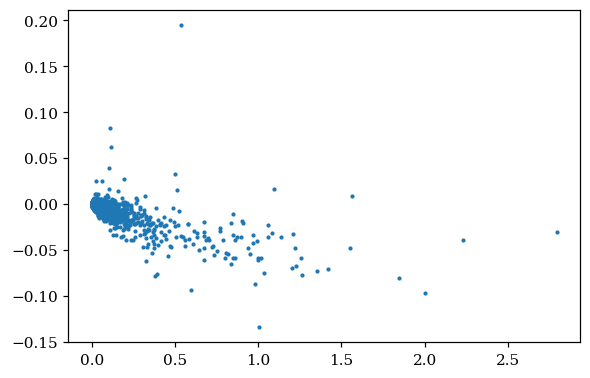

In [63]:
plt.scatter(avgs, log2fcs, s = 3)

### Saving filtered count matrix

In [41]:
sc_s.save_files(pp="filtered")